<a href="https://colab.research.google.com/github/ilhamfahmi11/Analisis-Text-Data-Instagram-X/blob/main/crawling_X.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1><u>PROSES PENGAMBILAN DATA X</u></h1>

In [ ]:
# @title Crawling Data X

import time, random, os

twitter_auth_token = os.getenv("TWITTER_BEARER_TOKEN", "")

# 2. Konfigurasi kata kunci & parameter crawl
keywords = [
    "Subsidi BBM",
    "BBM Pertalite",
    "BBM Subsidi Tidak Tepat Sasaran",
    "Bensin Subsidi",
    "Kebijakan BBM Subsidi",
    "Kendaraan BBM Subsidi",
    "Mobil Mewah Pertalite",
    "Pembatasan BBM Subsidi",
]

since_date  = "2024-01-01"
until_date  = "2025-01-01"
limit_each  = 500        # tweet per kata kunci
delay_cli   = 60         # 60 detik di dalam tweet-harvest (-d 60)
delay_kw    = 15 * 60    # 15 menit antar kata kunci

# 3. Loop crawl
for kw in keywords:
    filename      = f"crawl_{kw.replace(' ', '_').lower()}.csv"
    search_query  = f'{kw} since:{since_date} until:{until_date} lang:id'

    print(f"▶️  Crawling: “{kw}” (limit {limit_each}) …")

    # Perintah tweet-harvest — perhatikan opsi -d 60
    !npx -y tweet-harvest@2.6.1 \
        -o "{filename}" \
        -s "{search_query}" \
        --tab "LATEST" \
        -l {limit_each} \
        -d {delay_cli} \
        --token {twitter_auth_token}

    print(f"⏸️  Selesai “{kw}”. Tunggu 15 menit sebelum kata kunci berikutnya …\n")
    time.sleep(delay_kw)

print("✅ Semua crawl selesai!")

In [ ]:
import pandas as pd

df = pd.read_csv("crawling_x_all.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2885 entries, 0 to 2884
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   conversation_id_str      2885 non-null   int64  
 1   created_at               2885 non-null   object 
 2   favorite_count           2885 non-null   int64  
 3   full_text                2885 non-null   object 
 4   id_str                   2885 non-null   int64  
 5   image_url                609 non-null    object 
 6   in_reply_to_screen_name  1227 non-null   object 
 7   lang                     2885 non-null   object 
 8   location                 0 non-null      float64
 9   quote_count              2885 non-null   int64  
 10  reply_count              2885 non-null   int64  
 11  retweet_count            2885 non-null   int64  
 12  tweet_url                2885 non-null   object 
 13  user_id_str              2885 non-null   int64  
 14  username                

In [ ]:
df = pd.DataFrame(df[['full_text']])
df.head(5)

,full_text
0,Berikut Daftar Motor dan Mobil yang Dilarang I...
1,@txtdrimedia Gua sebagai ojol sudah lama menin...
2,Daftar Harga BBM Pertamina 30 November 2024 Te...
3,@YoezZar @vanc1Bozz @KementerianESDM Dr pd cab...
4,@txtdrimedia bukanya kalo ngisi BBM itu hak pr...


In [ ]:
df = df.dropna() # menghapus data kosong / NaN

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2885 entries, 0 to 2884
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   full_text  2885 non-null   object
dtypes: object(1)
memory usage: 22.7+ KB


In [ ]:
df.drop_duplicates(subset ="full_text", keep = 'first', inplace = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2704 entries, 0 to 2884
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   full_text  2704 non-null   object
dtypes: object(1)
memory usage: 42.2+ KB


<h1><u>PREPROCESSING DATA</u></h1>


In [ ]:
# Proses Data Cleaning
import re
import string
import nltk

# Fungsi untuk menghapus URL
def remove_URL(tweet):
    if tweet is not None and isinstance(tweet, str):
        url = re.compile(r'https?://\S+|www\.\S+')
        return url.sub(r'', tweet)
    else:
        return tweet

# Fungsi untuk menghapus HTML
def remove_html(tweet):
    if tweet is not None and isinstance(tweet, str):
        html = re.compile(r'<.*?>')
        return html.sub(r'', tweet)
    else:
        return tweet

# Fungsi untuk menghapus emoji
def remove_emoji(tweet):
    if tweet is not None and isinstance(tweet, str):
        emoji_pattern = re.compile("["
            u"\U0001F600-\U0001F64F"  # emoticons
            u"\U0001F300-\U0001F5FF"  # symbols & pictographs
            u"\U0001F680-\U0001F6FF"  # transport & map symbols
            u"\U0001F700-\U0001F77F"  # alchemical symbols
            u"\U0001F780-\U0001F7FF"  # geometric shapes extended
            u"\U0001F800-\U0001F8FF"  # supplemental arrows
            u"\U0001F900-\U0001F9FF"  # supplemental symbols & pictographs
            u"\U0001FA00-\U0001FA6F"  # chess symbols
            u"\U0001FA70-\U0001FAFF"  # symbols & pictographs extends
            u"\U0001F004-\U0001F0CF"  # additional emoticons
            u"\U0001F1E0-\U0001F1FF"  # flags
            "]+", flags=re.UNICODE)
        return emoji_pattern.sub(r'', tweet)
    else:
        return tweet

# Fungsi untuk menghapus simbol
def remove_symbols(tweet):
    if tweet is not None and isinstance(tweet, str):
        return re.sub(r'[^a-zA-Z0-9\s]', '', tweet)  # menghapus semua simbol
    else:
        return tweet

# Fungsi untuk menghapus angka
def remove_number(tweet):
    if tweet is not None and isinstance(tweet, str):
        return re.sub(r'\d', '', tweet)  # menghapus semua angka
    else:
        return tweet

# Fungsi untuk menghapus username
def remove_username(text):
    if text is not None and isinstance(text, str):
        return re.sub(r'@[^\s]+', '', text)
    else:
        return text

# Penerapan fungsi cleaning
df['clean_text'] = df['full_text'].apply(lambda x: remove_URL(x))
df['clean_text'] = df['clean_text'].apply(lambda x: remove_username(x))
df['clean_text'] = df['clean_text'].apply(lambda x: remove_html(x))
df['clean_text'] = df['clean_text'].apply(lambda x: remove_emoji(x))
df['clean_text'] = df['clean_text'].apply(lambda x: remove_symbols(x))
df['clean_text'] = df['clean_text'].apply(lambda x: remove_number(x))

# Tampilkan Hasil Akhir
print("Hasil clean_text X :")

# Menampilkan hasil
df.head(5)


Hasil clean_text X :


,full_text,clean_text
0,Berikut Daftar Motor dan Mobil yang Dilarang I...,Berikut Daftar Motor dan Mobil yang Dilarang I...
1,@txtdrimedia Gua sebagai ojol sudah lama menin...,Gua sebagai ojol sudah lama meninggalkan BBM ...
2,Daftar Harga BBM Pertamina 30 November 2024 Te...,Daftar Harga BBM Pertamina November Terlengk...
3,@YoezZar @vanc1Bozz @KementerianESDM Dr pd cab...,Dr pd cabut subsidi BBM Pertalite unt Ojol ...
4,@txtdrimedia bukanya kalo ngisi BBM itu hak pr...,bukanya kalo ngisi BBM itu hak pribadi ya mau...


In [ ]:
# Proses Case Folding

def case_folding(text):
    if isinstance(text, str):
      lowercase_text = text.lower()
      return lowercase_text
    else:
        return text

df['case_folding'] = df['clean_text'].apply(case_folding)

# Tampilkan Hasil Akhir
print("Hasil case_folding x :")

# Tampilkan DataFrame untuk melihat hasilnya
df[['clean_text', 'case_folding']].head(5)

Hasil case_folding x :


,clean_text,case_folding
0,Berikut Daftar Motor dan Mobil yang Dilarang I...,berikut daftar motor dan mobil yang dilarang i...
1,Gua sebagai ojol sudah lama meninggalkan BBM ...,gua sebagai ojol sudah lama meninggalkan bbm ...
2,Daftar Harga BBM Pertamina November Terlengk...,daftar harga bbm pertamina november terlengk...
3,Dr pd cabut subsidi BBM Pertalite unt Ojol ...,dr pd cabut subsidi bbm pertalite unt ojol ...
4,bukanya kalo ngisi BBM itu hak pribadi ya mau...,bukanya kalo ngisi bbm itu hak pribadi ya mau...


In [ ]:
# Proses Normalization

import pandas as pd

# Fungsi Normalisasi: Mengganti kata tidak baku dengan kata baku
def replace_taboo_words(text, kamus_tidak_baku):
    if isinstance(text, str):  # Pastikan input adalah string
        words = text.split()   # Pisahkan kata per kata
        replaced_words = []    # List untuk kata hasil penggantian

        for word in words:
            # Jika kata ada dalam kamus, ganti dengan kata baku
            if word in kamus_tidak_baku:
                replaced_words.append(kamus_tidak_baku[word])
            else:  # Jika tidak ada di kamus, gunakan kata asli
                replaced_words.append(word)

        replaced_text = ' '.join(replaced_words)  # Gabungkan kembali menjadi kalimat
        return replaced_text
    return text  # Jika bukan string, kembalikan teks apa adanya

# 1. Membaca Kamus Kata Tidak Baku
# Path file kamus kata tidak baku
kamus_data = pd.read_csv("kamuskatabaku.csv")
kamus_tidak_baku = dict(zip(kamus_data['tidak_baku'], kamus_data['kata_baku']))

# 2. Proses Normalisasi
# Terapkan normalisasi pada kolom `case_folding` dari DataFrame `df`
df['hasil_normalisasi'] = df['case_folding'].apply(lambda x: replace_taboo_words(x, kamus_tidak_baku))

# 3. Tampilkan Hasil Akhir
print("Hasil Normalisasi x :")
# Tampilkan DataFrame untuk melihat hasilnya
df[['case_folding', 'hasil_normalisasi']].head(5)


Hasil Normalisasi x :


,case_folding,hasil_normalisasi
0,berikut daftar motor dan mobil yang dilarang i...,berikut daftar motor dan mobil yang dilarang i...
1,gua sebagai ojol sudah lama meninggalkan bbm ...,saya sebagai ojek online sudah lama meninggalk...
2,daftar harga bbm pertamina november terlengk...,daftar harga bbm pertamina november terlengkap...
3,dr pd cabut subsidi bbm pertalite unt ojol ...,dari pada cabut subsidi bbm pertalite untuk oj...
4,bukanya kalo ngisi bbm itu hak pribadi ya mau...,bukanya kalaupun isi bbm itu hak pribadi ya ma...


In [ ]:
# Proses Tokenization (memecah teks menjadi kata-kata/token)

def tokenize(text):
    tokens = text.split() # Memecah teks menjadi daftar kata berdasarkan spasi
    return tokens # Mengembalikan daftar kata (token)

df['tokenize'] = df['hasil_normalisasi'].apply(tokenize)

# 3. Tampilkan Hasil Akhir
print("Hasil Tokenize x :")
# Tampilkan DataFrame untuk melihat hasilnya
df[['hasil_normalisasi', 'tokenize']].head(5)

Hasil Tokenize x :


,hasil_normalisasi,tokenize
0,berikut daftar motor dan mobil yang dilarang i...,"[berikut, daftar, motor, dan, mobil, yang, dil..."
1,saya sebagai ojek online sudah lama meninggalk...,"[saya, sebagai, ojek, online, sudah, lama, men..."
2,daftar harga bbm pertamina november terlengkap...,"[daftar, harga, bbm, pertamina, november, terl..."
3,dari pada cabut subsidi bbm pertalite untuk oj...,"[dari, pada, cabut, subsidi, bbm, pertalite, u..."
4,bukanya kalaupun isi bbm itu hak pribadi ya ma...,"[bukanya, kalaupun, isi, bbm, itu, hak, pribad..."


In [ ]:
# Proses Stopword Removal

from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = stopwords.words('indonesian')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# Fungsi untuk menghapus stopword dari list kata
def remove_stopwords(text):
    return [word for word in text if word not in stop_words]

df['stopword_removal'] = df['tokenize'].apply(lambda x: remove_stopwords(x))
# Tampilkan Hasil Akhir
print("Hasil stopword_removal x :")
# Tampilkan DataFrame untuk melihat hasilnya
df[['tokenize', 'stopword_removal']].head(5)

Hasil stopword_removal x :


,tokenize,stopword_removal
0,"[berikut, daftar, motor, dan, mobil, yang, dil...","[daftar, motor, mobil, dilarang, isi, bbm, per..."
1,"[saya, sebagai, ojek, online, sudah, lama, men...","[ojek, online, meninggalkan, bbm, pertamina, k..."
2,"[daftar, harga, bbm, pertamina, november, terl...","[daftar, harga, bbm, pertamina, november, terl..."
3,"[dari, pada, cabut, subsidi, bbm, pertalite, u...","[cabut, subsidi, bbm, pertalite, ojek, online,..."
4,"[bukanya, kalaupun, isi, bbm, itu, hak, pribad...","[bukanya, isi, bbm, hak, pribadi, ya, makai, p..."


In [ ]:
# Proses Stemming

!pip install Sastrawi
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from nltk.stem.snowball import SnowballStemmer

In [ ]:
Factory = StemmerFactory() # Membuat factory stemmer
stemmer = Factory.create_stemmer()

def stem_text(text):
    return [stemmer.stem(word) for word in text]

df['steming_data'] = df['stopword_removal'].apply(lambda x: ' '.join(stem_text(x)))
print("Hasil steming_data x :")
# Tampilkan DataFrame untuk melihat hasilnya
df[['stopword_removal', 'steming_data']].head(5)

Hasil steming_data x :


,stopword_removal,steming_data
0,"[daftar, motor, mobil, dilarang, isi, bbm, per...",daftar motor mobil larang isi bbm pertalite sp...
1,"[ojek, online, meninggalkan, bbm, pertamina, k...",ojek online tinggal bbm pertamina kotor pertam...
2,"[daftar, harga, bbm, pertamina, november, terl...",daftar harga bbm pertamina november lengkap je...
3,"[cabut, subsidi, bbm, pertalite, ojek, online,...",cabut subsidi bbm pertalite ojek online yo men...
4,"[bukanya, isi, bbm, hak, pribadi, ya, makai, p...",buka isi bbm hak pribadi ya maka pertalite per...


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2704 entries, 0 to 2884
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   full_text          2704 non-null   object
 1   clean_text         2704 non-null   object
 2   case_folding       2704 non-null   object
 3   hasil_normalisasi  2704 non-null   object
 4   tokenize           2704 non-null   object
 5   stopword_removal   2704 non-null   object
 6   steming_data       2704 non-null   object
dtypes: object(7)
memory usage: 169.0+ KB


In [ ]:
# download hasil preprocessing ke csv
df.to_csv('hasil_preprocessing_data_x.csv', index=False, encoding='utf-8')

<h1><u>ANALISIS SENTIMEN</u></h1>

In [ ]:
!pip install vaderSentiment
!pip install googletrans==4.0.0-rc1

In [ ]:
# Import library NLTK (Natural Language Toolkit)
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [ ]:
import pandas as pd
df = pd.read_csv('hasil_preprocessing_data_x.csv')
df.head (5)

,full_text,clean_text,case_folding,hasil_normalisasi,tokenize,stopword_removal,steming_data
0,Berikut Daftar Motor dan Mobil yang Dilarang I...,Berikut Daftar Motor dan Mobil yang Dilarang I...,berikut daftar motor dan mobil yang dilarang i...,berikut daftar motor dan mobil yang dilarang i...,"['berikut', 'daftar', 'motor', 'dan', 'mobil',...","['daftar', 'motor', 'mobil', 'dilarang', 'isi'...",daftar motor mobil larang isi bbm pertalite sp...
1,@txtdrimedia Gua sebagai ojol sudah lama menin...,Gua sebagai ojol sudah lama meninggalkan BBM ...,gua sebagai ojol sudah lama meninggalkan bbm ...,saya sebagai ojek online sudah lama meninggalk...,"['saya', 'sebagai', 'ojek', 'online', 'sudah',...","['ojek', 'online', 'meninggalkan', 'bbm', 'per...",ojek online tinggal bbm pertamina kotor pertam...
2,Daftar Harga BBM Pertamina 30 November 2024 Te...,Daftar Harga BBM Pertamina November Terlengk...,daftar harga bbm pertamina november terlengk...,daftar harga bbm pertamina november terlengkap...,"['daftar', 'harga', 'bbm', 'pertamina', 'novem...","['daftar', 'harga', 'bbm', 'pertamina', 'novem...",daftar harga bbm pertamina november lengkap je...
3,@YoezZar @vanc1Bozz @KementerianESDM Dr pd cab...,Dr pd cabut subsidi BBM Pertalite unt Ojol ...,dr pd cabut subsidi bbm pertalite unt ojol ...,dari pada cabut subsidi bbm pertalite untuk oj...,"['dari', 'pada', 'cabut', 'subsidi', 'bbm', 'p...","['cabut', 'subsidi', 'bbm', 'pertalite', 'ojek...",cabut subsidi bbm pertalite ojek online yo men...
4,@txtdrimedia bukanya kalo ngisi BBM itu hak pr...,bukanya kalo ngisi BBM itu hak pribadi ya mau...,bukanya kalo ngisi bbm itu hak pribadi ya mau...,bukanya kalaupun isi bbm itu hak pribadi ya ma...,"['bukanya', 'kalaupun', 'isi', 'bbm', 'itu', '...","['bukanya', 'isi', 'bbm', 'hak', 'pribadi', 'y...",buka isi bbm hak pribadi ya maka pertalite per...


In [ ]:
from googletrans import Translator

# Inisialisasi objek Translator
translator = Translator()

# Fungsi untuk menerjemahkan teks dan menjaga format huruf kecil
def translate_to_english(text):
    try:
        # Menerjemahkan teks ke dalam bahasa Inggris
        translated = translator.translate(text, src='id', dest='en')
        # Mengembalikan hasil terjemahan dalam huruf kecil
        return translated.text.lower()
    except Exception as e:
        return str(e)

# Terapkan penerjemahan pada data yang telah melalui proses stemming
df['translated_text'] = df['steming_data'].apply(lambda x: translate_to_english(x))

print("Hasil translated x :")
# Tampilkan DataFrame untuk melihat hasilnya
df[['steming_data', 'translated_text']].head(5)


Hasil translated x :


,steming_data,translated_text
0,daftar motor mobil larang isi bbm pertalite sp...,list of motorbikes for car bbu fill in bbm per...
1,ojek online tinggal bbm pertamina kotor pertam...,online motorcycle taxi is only pertamina's bbm...
2,daftar harga bbm pertamina november lengkap je...,list of pertamina november fuel prices complet...
3,cabut subsidi bbm pertalite ojek online yo men...,unplug the fuel subsidy of online motorcycle t...
4,buka isi bbm hak pribadi ya maka pertalite per...,"open the contents of the bbm rights, then pert..."


In [ ]:
import pandas as pd
df = pd.read_csv('hasil_analisis_sentimen_x.csv')

In [ ]:
from nltk.sentiment import SentimentIntensityAnalyzer

# Inisialisasi objek SentimentIntensityAnalyzer
sentiments = SentimentIntensityAnalyzer()

# Fungsi untuk analisis sentimen
def analyze_sentiment(text):
    score = sentiments.polarity_scores(text)
    return score['compound']

# Terapkan analisis sentimen pada teks yang sudah diterjemahkan
df["compound_score"] = df['translated_text'].apply(analyze_sentiment)

df["sentiment"] = df["compound_score"].apply(lambda x: 'positif' if x >= 0.05 else ('negatif' if x <= -0.05 else 'netral'))

# Hitung jumlah sentimen
positif = df["sentiment"].value_counts().get("positif", 0)
negatif = df["sentiment"].value_counts().get("negatif", 0)
netral = df["sentiment"].value_counts().get("netral", 0)

# Menampilkan hasil analisis
print("Hasil Sentimen X")
print("Jumlah Sentimen Positif:", positif)
print("Jumlah Sentimen Negatif:", negatif)
print("Jumlah Sentimen Netral:", netral)

# Tampilkan DataFrame untuk melihat hasilnya
df[['steming_data', 'translated_text', 'compound_score', 'sentiment']].head(5)


Hasil Sentimen X
Jumlah Sentimen Positif: 671
Jumlah Sentimen Negatif: 1303
Jumlah Sentimen Netral: 730


,steming_data,translated_text,compound_score,sentiment
0,daftar motor mobil larang isi bbm pertalite sp...,list of motorbikes for car bbu fill in bbm per...,0.0000,netral
1,ojek online tinggal bbm pertamina kotor pertam...,online motorcycle taxi is only pertamina's bbm...,-0.4404,negatif
2,daftar harga bbm pertamina november lengkap je...,list of pertamina november fuel prices complet...,0.0000,netral
3,cabut subsidi bbm pertalite ojek online yo men...,unplug the fuel subsidy of online motorcycle t...,-0.6486,negatif
4,buka isi bbm hak pribadi ya maka pertalite per...,"open the contents of the bbm rights, then pert...",0.0000,netral


In [ ]:
# Download hasil sentimen x ke csv
df.to_csv('hasil_analisis_sentimen_x.csv', index=False, encoding='utf-8')

In [ ]:
import pandas as pd

df = pd.read_csv('hasil_analisis_sentimen_x.csv')  # ganti nama file sesuai file kamu


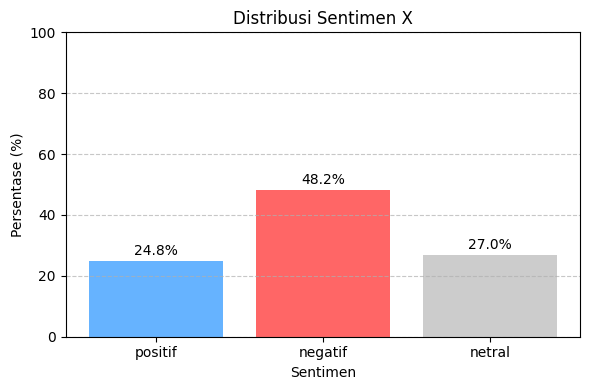

In [ ]:
import matplotlib.pyplot as plt

# Hitung jumlah sentimen positif, negatif, dan netral (sertakan semua meskipun nol)
sentiment_counts = df['sentiment'].value_counts().reindex(['positif', 'negatif', 'netral'], fill_value=0)

# Hitung persentase
sentiment_percentages = (sentiment_counts / sentiment_counts.sum()) * 100

# Warna-warna untuk tiap label
colors = ['#66b3ff', '#ff6666', '#cccccc']  # Biru untuk positif, merah untuk negatif, abu untuk netral

# Buat bar chart
plt.figure(figsize=(6, 4))
bars = plt.bar(sentiment_percentages.index, sentiment_percentages.values, color=colors)

# Tambahkan label persentase di atas setiap bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, f'{yval:.1f}%', ha='center', va='bottom')

plt.title('Distribusi Sentimen X')
plt.xlabel('Sentimen')
plt.ylabel('Persentase (%)')
plt.ylim(0, 100)  # agar sumbu y selalu maksimal 100%
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()



<h1><u>PROSES LDA</u></h1>


In [ ]:
!pip install --upgrade gensim==4.3.2 scipy==1.10.1

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Label unik: ['netral' 'negatif' 'positif']
sentiment
negatif    1303
netral      730
positif     671
Name: Jumlah per label, dtype: int64

📊 Nilai Koherensi (Positif)
------------------------------
Topik 2: 0.1876
Topik 3: 0.2351
Topik 4: 0.2724
Topik 5: 0.3157

📊 Nilai Koherensi (Negatif)
------------------------------
Topik 2: 0.1892
Topik 3: 0.2507
Topik 4: 0.2422
Topik 5: 0.2516


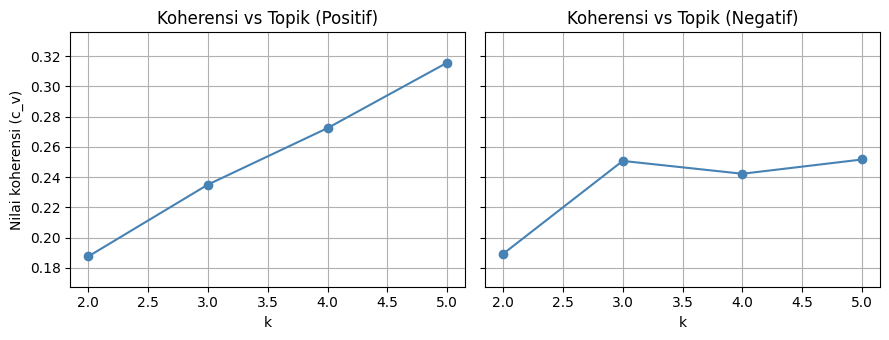

===== NILAI BOBOT KATA TERATAS PER TOPIK =====

===== POSITIF =====
Topik 1          Topik 2             Topik 3             Topik 4              Topik 5         
gratis (0.0382)  sasaran (0.0396)    pertalite (0.0472)  pembatasan (0.0518)  ojek (0.0269)   
makan (0.0320)   kendaraan (0.0391)  kendaraan (0.0395)  pertalite (0.0406)   online (0.0269) 
pajak (0.0303)   pakai (0.0377)      pertamina (0.0346)  kebijakan (0.0216)   listrik (0.0252)

===== NEGATIF =====
Topik 1             Topik 2             Topik 3            
ojek (0.0463)       harga (0.0296)      mobil (0.0333)     
online (0.0461)     pertalite (0.0288)  pertalite (0.0316) 
kebijakan (0.0287)  kebijakan (0.0255)  pembatasan (0.0307)


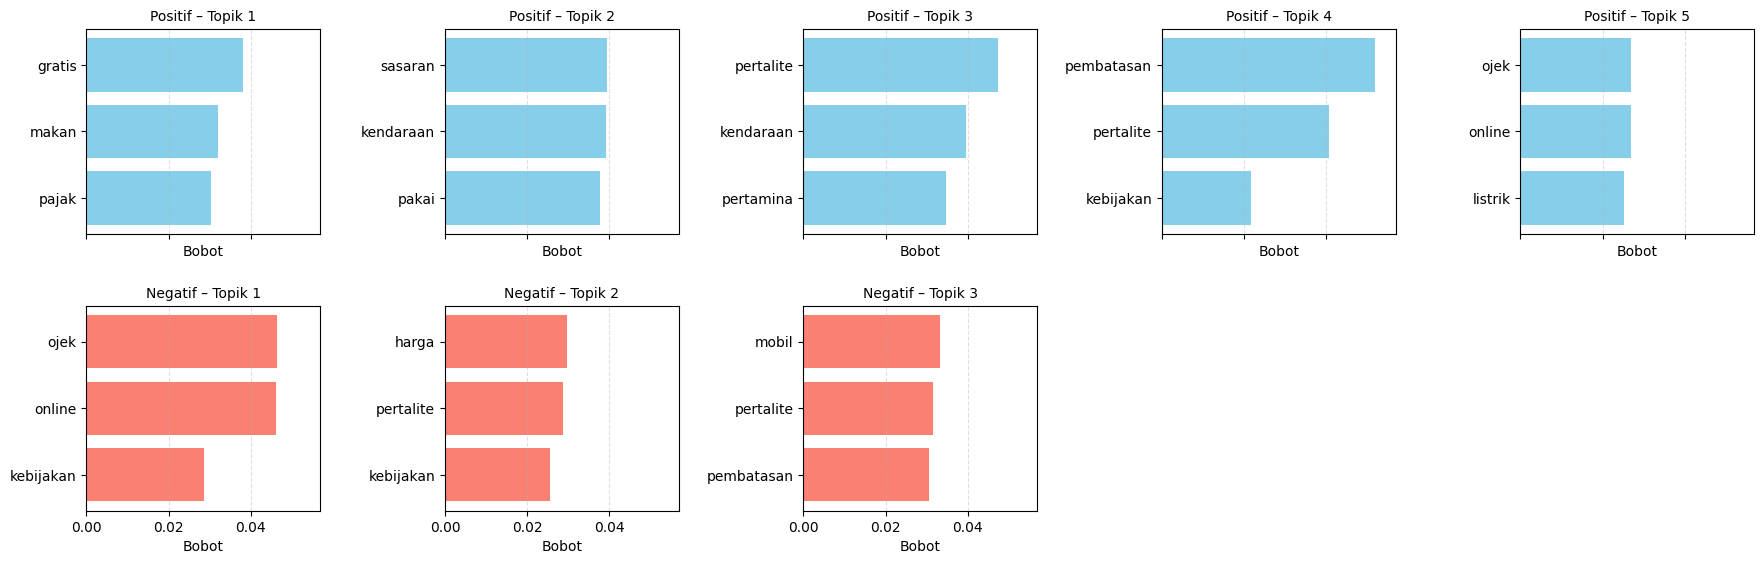

 File 'hasil_topik_dominan_x.csv' berhasil disimpan.


In [ ]:
# ======== IMPORT LIBRARY ========
import pandas as pd
import matplotlib.pyplot as plt  # Untuk visualisasi grafik
import numpy as np # Untuk perhitungan numerik
import nltk, warnings # Untuk NLP dan manajemen warning
from gensim import corpora # Untuk membuat dictionary
from gensim.models import LdaModel, CoherenceModel # Untuk LDA dan evaluasi koherensi
from nltk.corpus import stopwords # Untuk stopwords Bahasa Indonesia

# Unduh stopwords bahasa Indonesia
nltk.download('stopwords')
warnings.filterwarnings("ignore", category=DeprecationWarning)

# ======== BACA DATA DAN TOKENISASI ========
FILE = "hasil_analisis_sentimen_x.csv"
df = pd.read_csv(FILE)
df['tokens'] = df['stopword_removal'].apply(eval)

# Cek distribusi label sentimen
print("Label unik:", df['sentiment'].unique())
print(df['sentiment'].value_counts().rename("Jumlah per label"))

# ======== PISAHKAN DATA BERDASARKAN SENTIMEN ========
df_pos = df[df['sentiment'] == 'positif'].copy()
df_neg = df[df['sentiment'] == 'negatif'].copy()

# ======== PEMBERSIHAN TOKEN DENGAN STOPWORDS ========
stop_words = set(stopwords.words('indonesian'))
stop_words.update({'nya', 'aja', 'dong','isi', 'sih', 'ya', 'deh', 'mah', 'h'})

def clean_tokens(series):
    return [[w for w in doc if w not in stop_words] for doc in series]

clean_pos = clean_tokens(df_pos['tokens'])
clean_neg = clean_tokens(df_neg['tokens'])

# ======== FUNGSI MEMBANGUN CORPUS DAN DICTIONARY ========
def build_corpus(texts):
    dictionary = corpora.Dictionary(texts) # Buat kamus dari teks
    dictionary.filter_extremes(no_below=3, no_above=0.7) # Filter kata terlalu umum/asing
    corpus = [dictionary.doc2bow(t) for t in texts]  # Konversi dokumen jadi bag-of-words
    return corpus, dictionary

# ======== HITUNG NILAI KOHERENSI UNTUK MENENTUKAN JUMLAH TOPIK OPTIMAL (tertinggi) ========
def coherence_scores(cleaned, label=""):
    corpus, dictionary = build_corpus(cleaned)
    ks = range(2, 6) # Rentang jumlah topik yang akan diuji
    out = []
    print(f"\n📊 Nilai Koherensi ({label})")
    print("-" * 30)
    for k in ks:
        lda = LdaModel(corpus=corpus, id2word=dictionary,
                       num_topics=k, passes=10, random_state=42) # LDA model dengan k topik
        cv = CoherenceModel(model=lda, texts=cleaned,
                            dictionary=dictionary, coherence='c_v').get_coherence() # Hitung nilai koherensi
        print(f"Topik {k}: {cv:.4f}")
        out.append((k, cv))
    return out

# Koherensi untuk masing-masing sentimen
scores_pos = coherence_scores(clean_pos, label="Positif")
scores_neg = coherence_scores(clean_neg, label="Negatif")

# Ambil nilai koherensi dan jumlah topik untuk plot
(ks_pos, cv_pos), (ks_neg, cv_neg) = zip(*scores_pos), zip(*scores_neg)

# ======== PLOT NILAI KOHERENSI UNTUK POSITIF DAN NEGATIF ========
ymin = min(min(cv_pos), min(cv_neg)) - 0.02
ymax = max(max(cv_pos), max(cv_neg)) + 0.02

fig, ax = plt.subplots(1, 2, figsize=(9, 3.5), sharey=True)
for a, (ks, cvs, lbl) in zip(ax, [(ks_pos, cv_pos, "Positif"),
                                  (ks_neg, cv_neg, "Negatif")]):
    a.plot(ks, cvs, marker='o', color='steelblue')
    a.set_title(f"Koherensi vs Topik ({lbl})")
    a.set_xlabel("k")
    a.grid(True)
    a.set_ylim(ymin, ymax)
ax[0].set_ylabel("Nilai koherensi (c_v)")
plt.tight_layout()
plt.show()

# ======== LATIH MODEL FINAL DENGAN JUMLAH TOPIK TERPILIH ========
def train_lda(cleaned, k=5):
    corpus, dictionary = build_corpus(cleaned)
    return LdaModel(corpus=corpus, id2word=dictionary,
                    num_topics=k, passes=20, alpha='auto',
                    random_state=42) # Training model akhir LDA

lda_pos = train_lda(clean_pos, k=5)
lda_neg = train_lda(clean_neg, k=3)

# ======== AMBIL KATA DAN BOBOT UNTUK TIAP TOPIK ========
def topic_words(lda, topn=3):
    return [[w for w,_ in lda.show_topic(i, topn=topn)] for i in range(lda.num_topics)] # kata-kata teratas

def topic_weights(lda, topn=3):
    return [[w for _,w in lda.show_topic(i, topn=topn)] for i in range(lda.num_topics)] # bobot kata

twords_pos, tweights_pos = topic_words(lda_pos), topic_weights(lda_pos)
twords_neg, tweights_neg = topic_words(lda_neg), topic_weights(lda_neg)

# ======== CETAK NILAI BOBOT KATA TERATAS PER TOPIK ========
def print_bobot_horizontal(words_list, weights_list, label):
    n_topic = len(words_list)
    topn = len(words_list[0])
    cells = [[f"{words_list[col][row]} ({weights_list[col][row]:.4f})"
              for col in range(n_topic)]
             for row in range(topn)]
    col_widths = [max(len(cells[row][col]) for row in range(topn))
                  for col in range(n_topic)]

    print(f"\n===== {label.upper()} =====")
    header = [f"Topik {i+1}".ljust(col_widths[i]) for i in range(n_topic)]
    print("  ".join(header))

    for row in range(topn):
        line = [cells[row][col].ljust(col_widths[col]) for col in range(n_topic)]
        print("  ".join(line))

print("===== NILAI BOBOT KATA TERATAS PER TOPIK =====")
print_bobot_horizontal(twords_pos, tweights_pos, "positif")
print_bobot_horizontal(twords_neg, tweights_neg, "negatif")

# ======== VISUALISASI BATANG TOPIK POSITIF & NEGATIF ========
fig, axes = plt.subplots(2, 5, figsize=(18, 6), sharex=True)

x_max = 1.1 * max(max(map(max, tweights_pos)), max(map(max, tweights_neg)))

def plot_topic(ax, words, weights, title, color):
    ax.barh(words, weights, color=color)
    ax.invert_yaxis()
    ax.set_title(title, fontsize=10)
    ax.set_xlim(0, x_max)
    ax.set_xlabel("Bobot")
    ax.grid(axis='x', linestyle='--', alpha=.4)

# Plot untuk topik positif
for i in range(5):
    plot_topic(axes[0, i], twords_pos[i], tweights_pos[i], f"Positif – Topik {i+1}", "skyblue")

# Plot untuk topik negatif
for i in range(3):
    plot_topic(axes[1, i], twords_neg[i], tweights_neg[i], f"Negatif – Topik {i+1}", "salmon")

# Kosongkan sisa kolom negatif
for i in range(3, 5):
    axes[1, i].axis('off')

plt.tight_layout(pad=2)
plt.show()

# ======== SIMPAN TOPIK DOMINAN & 3 KATA TERATAS KE FILE CSV ========
def get_topic_distributions(lda_model, corpus):
    return [max(lda_model.get_document_topics(doc), key=lambda x: x[1])[0] for doc in corpus] # Topik dominan

corpus_pos, _ = build_corpus(clean_pos)
df_pos['topik_dominan'] = get_topic_distributions(lda_pos, corpus_pos)

corpus_neg, _ = build_corpus(clean_neg)
df_neg['topik_dominan'] = get_topic_distributions(lda_neg, corpus_neg)

def topik_ke_kata_teratas(twords):
    return {i: ', '.join(twords[i]) for i in range(len(twords))}

df_pos['kata_3_teratas'] = df_pos['topik_dominan'].map(topik_ke_kata_teratas(twords_pos))
df_neg['kata_3_teratas'] = df_neg['topik_dominan'].map(topik_ke_kata_teratas(twords_neg))

kolom_output = ['sentiment', 'hasil_normalisasi', 'topik_dominan', 'kata_3_teratas']
pd.concat([df_pos[kolom_output], df_neg[kolom_output]], ignore_index=True) \
  .to_csv("hasil_topik_dominan_x.csv", index=False, encoding='utf-8-sig')

print(" File 'hasil_topik_dominan_x.csv' berhasil disimpan.")


<h1><u>PROSES SUMMERIZE MENGGUNAKAN LEXRANK</u></h1>



In [ ]:
!pip install lexrank
!pip install sumy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.8/69.8 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 120.0/120.0 kB 6.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.3/97.3 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 57.2 MB/s eta 0:00:00
  Created wheel for breadability: filename=breadability-0.1.20-py2.py3-none-any.whl size=21693 sha256=1a65a5162ec5a8a89ed3a52b2a5b28fb6e523f838a4d409d81934c84552ee0be
  Stored in directory: /root/.cache/pip/wheels/4d/57/58/7e3d7fedf51fe248b7fcee3df6945ae28638e22cddf01eb92b
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=edd53cec0a3a6e255234cd48248f3232fbf935504e46a7d517fbc693a352c574
  Stored in directory: /root/.cache/pip/wheels/1a/b0/8c/4b75c4116c31f83c8f9f047231251e13cc74481cca4a78a9ce
Successfully built breadability docopt


In [ ]:
import pandas as pd
from lexrank import LexRank
from lexrank.mappings.stopwords import STOPWORDS
from nltk.tokenize import sent_tokenize
import nltk

nltk.download("punkt")

# ======== BACA FILE CSV ========
df = pd.read_csv("hasil_topik_dominan_x.csv")
df['hasil_normalisasi'] = df['hasil_normalisasi'].astype(str)
df['kata_3_teratas'] = df['kata_3_teratas'].astype(str)

# ======== FUNGSI RINGKASAN ========
def ringkasan_lexrank_per_topik(df, sentiment_label="positif", n_topik_target=5):
    hasil = [] # List untuk menyimpan hasil ringkasan
    df_label = df[df['sentiment'].str.lower() == sentiment_label.lower()] # Filter berdasarkan sentimen

    for i in range(n_topik_target):  # topik mulai dari 0
        topik_df = df_label[df_label['topik_dominan'] == i] # Ambil data untuk topik tertentu
        kalimat_list = topik_df['hasil_normalisasi'].dropna().drop_duplicates().tolist() # Ambil kalimat

        if not kalimat_list:  # Jika tidak ada kalimat relevan
            hasil.append({
                'Topik': f"{sentiment_label.title()} – Topik {i+1}",
                'Kata Kunci': "-",
                'Ringkasan': "Tidak ada kalimat relevan."
            })
            continue

        # Ambil kata kunci dari kolom
        kata_kunci_str = topik_df['kata_3_teratas'].dropna().values[0]
        kata_kunci = [k.strip() for k in kata_kunci_str.split(',')]

        # Ambil kalimat yang mengandung minimal 2 dari 3 kata kunci
        def cocok(kal):
            return sum(k in kal.split() for k in kata_kunci) >= 2

        kal_relevan = list(filter(cocok, kalimat_list))  # Kalimat yang relevan

        if not kal_relevan:
            hasil.append({
                'Topik': f"{sentiment_label.title()} – Topik {i+1}",
                'Kata Kunci': ", ".join(kata_kunci),
                'Ringkasan': "Tidak ada kalimat relevan."
            })
            continue

        # Tokenisasi per kalimat
        sentences = []
        for kal in kal_relevan:
            try:
                sentences.extend(sent_tokenize(kal))
            except:
                sentences.append(kal)

        # Jalankan LexRank
        try:
            docs = [s.split() for s in sentences]
            lxr = LexRank(docs, stopwords=STOPWORDS['en'])
            ringkasan = lxr.get_summary(sentences, summary_size=3, threshold=0.1)
        except Exception as e:
            print(f"[LexRank Error] Topik {i} {sentiment_label}: {e}")
            ringkasan = sentences[:3]

        # Validasi ringkasan mengandung semua kata kunci
        def mengandung_semua(kal):
            return all(k in kal.split() for k in kata_kunci)

        ringkasan_fix = [kal for kal in ringkasan if mengandung_semua(kal)]

        # Jika tidak ada yang mengandung semua, pakai ringkasan awal
        final_summary = ringkasan_fix if ringkasan_fix else ringkasan

        hasil.append({
            'Topik': f"{sentiment_label.title()} – Topik {i+1}",
            'Kata Kunci': ", ".join(kata_kunci),
            'Ringkasan': " ".join(final_summary)
        })

    return hasil

# ======== PROSES ========
hasil_pos = ringkasan_lexrank_per_topik(df, "positif", n_topik_target=5)
hasil_neg = ringkasan_lexrank_per_topik(df, "negatif", n_topik_target=3)

df_hasil = pd.DataFrame(hasil_pos + hasil_neg)

# ======== TAMPILKAN HASIL ========
print("\n📌 RINGKASAN PER TOPIK:")
for index, row in df_hasil.iterrows():
    print(f"\n📄 {row['Topik']}")
    print(f"Kata Kunci: {row['Kata Kunci']}")
    print(f"Ringkasan: {row['Ringkasan']}")

# ======== SIMPAN KE CSV ========
df_hasil.to_csv("hasil_ringkasan_lexrank_x.csv", index=False)
print("\n✅ File disimpan sebagai 'hasil_ringkasan_lexrank_x.csv'")


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!



📌 RINGKASAN PER TOPIK:

📄 Positif – Topik 1
Kata Kunci: gratis, makan, pajak
Ringkasan: kalaupun dibilang subsidi bbm tidak tepat sasaran program makan gratis juga dibagikan ke semua anak indonesia ya tidak tepat sasaran karena anak orang seperti juga dapat makan gratis logikanya bagaimana si anak orang seperti yang sudah kenyang juga dikasih makan uang drimana t nyinyir subsidi bbm dan gas akan dikurangi untuk maksi gratiskrn tidak tepat sasaran lah maksi gratis memang tepat sasaran makan gratis kalaupun tepat sasaran tidak masalahitu baguskayak di brazil tujuannya mencegah kelaparan tapi kalau anak orang seperti pejabatanak yang sudah berkecukupan gizi juga dapat itu namanya tidak tepat sasaranpersis seperti subsidi bbm dan gas belum lagi anggarannya bagaimana

📄 Positif – Topik 2
Kata Kunci: sasaran, kendaraan, pakai
Ringkasan: menarik juga pakai atau code buat beli pertalite biar subsidi lebih tepat sasaran jadi subsidi tidak asalasalan lagi sudah saatnya memang distribusi bbm leb